In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open("names.txt").read().splitlines()

In [5]:
len(words)

32033

In [17]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [33]:
block_size = 3
X, y = [], []


for w in words[:5]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        #print(ix," -> ",ch)
        X.append(context)
        y.append(ix)
        print(''.join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
y = torch.tensor(y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [34]:
X.shape, y.shape, X.dtype, y.dtype

(torch.Size([32, 3]), torch.Size([32]), torch.int64, torch.int64)

In [35]:
C = torch.randn((27,2))

In [56]:
C[X].shape
X[13,2]
C[X][13,2]
C[1]

tensor([-1.0778, -0.4870])

In [57]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [58]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [71]:
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]],1).shape
torch.cat(torch.unbind(emb, 1), 1).shape
emb.view(32,6).shape

torch.Size([32, 6])

In [75]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [77]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [79]:
logits = h @ W2 + b2

In [83]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim = True)

In [84]:
probs[0].sum()

tensor(1.0000)

In [86]:
loss = -probs[torch.arange(y.shape[0]), y].log().mean()
loss

tensor(14.5507)

### One Go MLP

In [109]:
block_size = 3
X, y = [], []


for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
y = torch.tensor(y)

In [110]:
X.shape, y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [148]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [149]:
sum(p.nelement() for p in parameters)

3481

In [150]:
for p in parameters:
    p.requires_grad = True

In [151]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [165]:
#lri = []
#lossi = []

for k in range(10000):

    #minibatch
    ix = torch.randint(0,X.shape[0], (32,))
    #forwrd
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y[ix])
    #print(f"loss on minibatch= {loss.item()}")

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    #lr = lrs[k]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    #lri.append(lre[k])
    #lossi.append(loss.item())

print(f"loss on minibatch= {loss.item()}")

loss on minibatch= 2.204190731048584


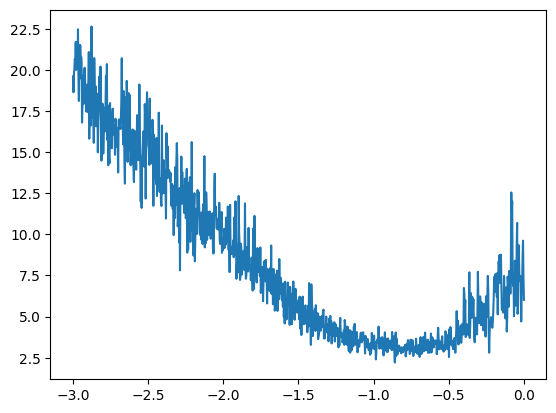

In [166]:
plt.plot(lri, lossi) # this gives us the confidence that what is the best lr

In [167]:
    emb = C[X]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f"loss on full training set= {loss.item()}")

loss on full training set= 2.302666664123535


In [168]:
#training split, valid split, test split
#80%, 10%, 10%

#build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [169]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [218]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [219]:
sum(p.nelement() for p in parameters)

11897

In [220]:
for p in parameters:
    p.requires_grad = True

In [221]:
lri = []
lossi = []
stepi = []

In [227]:
for k in range(200000):

    #minibatch
    ix = torch.randint(0,Xtr.shape[0], (32,))
    #forwrd
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(f"loss on minibatch= {loss.item()}")

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    #lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -0.01 * p.grad

    #track stats
    #lri.append(lre[k])
    stepi.append(k)
    lossi.append(loss.log10().item())

print(f"loss on minibatch= {loss.item()}")

loss on minibatch= 2.191338539123535


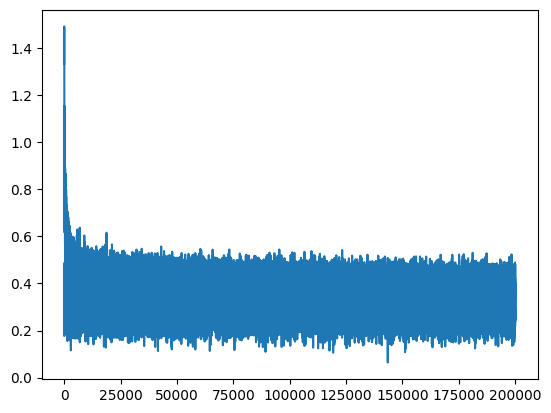

In [228]:
plt.plot(stepi, lossi)

In [229]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(f"loss on full training set= {loss.item()}")

loss on full training set= 2.0887773036956787


In [230]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(f"loss on full training set= {loss.item()}")

loss on full training set= 2.151124954223633


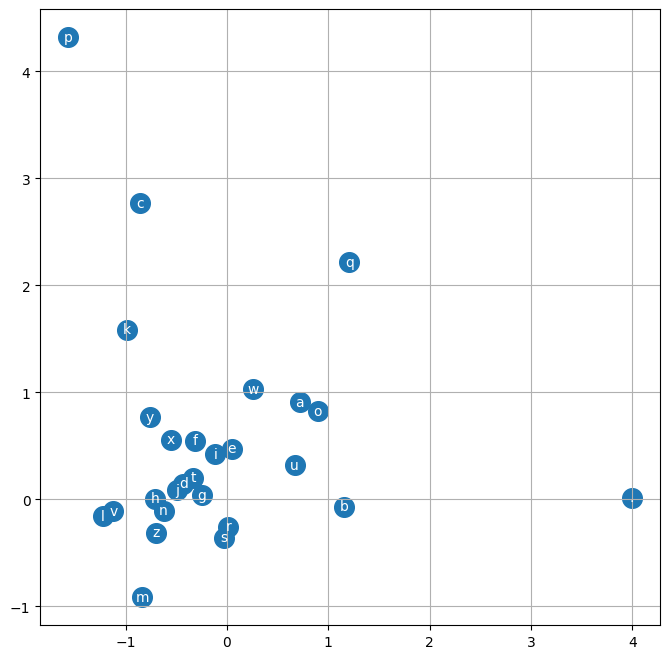

In [231]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [232]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahzamille.
khyliri.
rehty.
skanden.
jazon.
nadelynn.
jareen.
ner.
kiah.
maiif.
kaleigh.
ham.
join.
quint.
sulin.
alianni.
wazelo.
dearisi.
jace.
pirra.
